In [27]:
import glob
import pandas as pd
import pickle
import sympy
import networkx as nx
import numpy as np
from sympy.parsing.sympy_parser import parse_expr
from tqdm import tqdm
import matplotlib.pyplot as plt

In [28]:
def load_data_and_equation(eq_name,data_folder='../srsd-feynman_easy/train/',true_eq_folder='../srsd-feynman_easy/true_eq/'):
    dataframe = pd.read_csv(f'{data_folder}{eq_name}.txt',header=None,sep=' ')
    
    equation=load_equation(eq_name,true_eq_folder)
    
    names=[]
    substitution={}
    for var in range(len(dataframe.columns)-1):
        names.append(f'x_{var}^{{{eq_name}}}')
        xvar,new_xvar=sympy.symbols(f'x{var} {names[-1]}')
        substitution[xvar]=new_xvar
    equation=equation.subs(substitution)
    names.append(f'y^{{{eq_name}}}')
    #names=[f'${name}$' for name in names]
    
    dataframe.columns=names
    return dataframe,f'$y^{{{eq_name}}}={sympy.latex(equation)}$'

def load_equation(eq_name,equation_folder='../srsd-feynman_easy/true_eq/'):
    with open(f'{equation_folder}{eq_name}.pkl', 'rb') as f:
        equation = pickle.load(f)
        equation=parse_expr(str(equation)) #solving mysterious parsing issue in original equations
    return equation


In [29]:
def create_data(data_folder,eq_folder,num_of_original_data,num_of_intertwined_data):
    datas = glob.glob(data_folder+'*')
    dataframes=[]
    equations=[]
    random_equations=np.random.choice(datas,num_of_original_data+num_of_intertwined_data)
    for eq_chosen in random_equations[:num_of_original_data]:
        eq_name=eq_chosen.replace(data_folder,'').replace('.txt','')
        df,eq=load_data_and_equation(eq_name,data_folder=data_folder,true_eq_folder=eq_folder)
        dataframes.append(df)
        equations.append(eq)
    res=pd.concat(dataframes,axis=1)
    for eq_chosen in random_equations[num_of_original_data:]:
        eq_name=eq_chosen.replace(data_folder,'').replace('.txt','')
        equation=load_equation(eq_name=eq_name,equation_folder=eq_folder)
        variables = list(equation.atoms(sympy.Symbol))
        which_vars=np.random.choice(res.columns,len(variables))
        apply_equation=lambda X_dict:equation.evalf(subs={variable:X_dict[var] for variable,var in zip(variables,which_vars)})
        res[f'y^{{{eq_name}}}']=res.apply(apply_equation,axis=1)
        equation=equation.subs({variable:sympy.symbols(var)for variable,var in zip(variables,which_vars)})
        equations.append(f'$y^{{{eq_name}}}={sympy.latex(equation)}$')
    return res,equations

def from_dataframe_to_graph(dataframe,equations):
    df=dataframe.sample(frac=1,axis=1)
    new_names=[f'x_{{{i}}}' for i in range(len(df.columns))]
    old_to_new_names={name:new_name for name,new_name in zip(df.columns,new_names)}
    G=nx.DiGraph()
    G.add_nodes_from(new_names)
    nx.set_node_attributes(G, {name:f'${name}$' for name in new_names}, "equation")
    for old_name,new_name in zip(df.columns,new_names):
        if old_name[0]=='y':
            for equation in equations:
                
                LHS,RHS=tuple(equation.split('='))
                if old_name in LHS:
                    new_equation=equation.replace(old_name,new_name)
                    for old_variable in df.columns:
                        if old_variable in RHS:
                            G.add_edge(old_to_new_names[old_variable],new_name)
                            new_equation=new_equation.replace(old_variable,old_to_new_names[old_variable])
                    G.nodes[new_name]['equation']=new_equation
                    break
    df.columns=new_names
    return G,df




In [34]:
dataframe,equations=create_data(
    data_folder='../srsd-feynman_easy/train/',
    eq_folder='../srsd-feynman_easy/true_eq/',
    num_of_original_data=2,
    num_of_intertwined_data=2)

G,df=from_dataframe_to_graph(dataframe,equations)

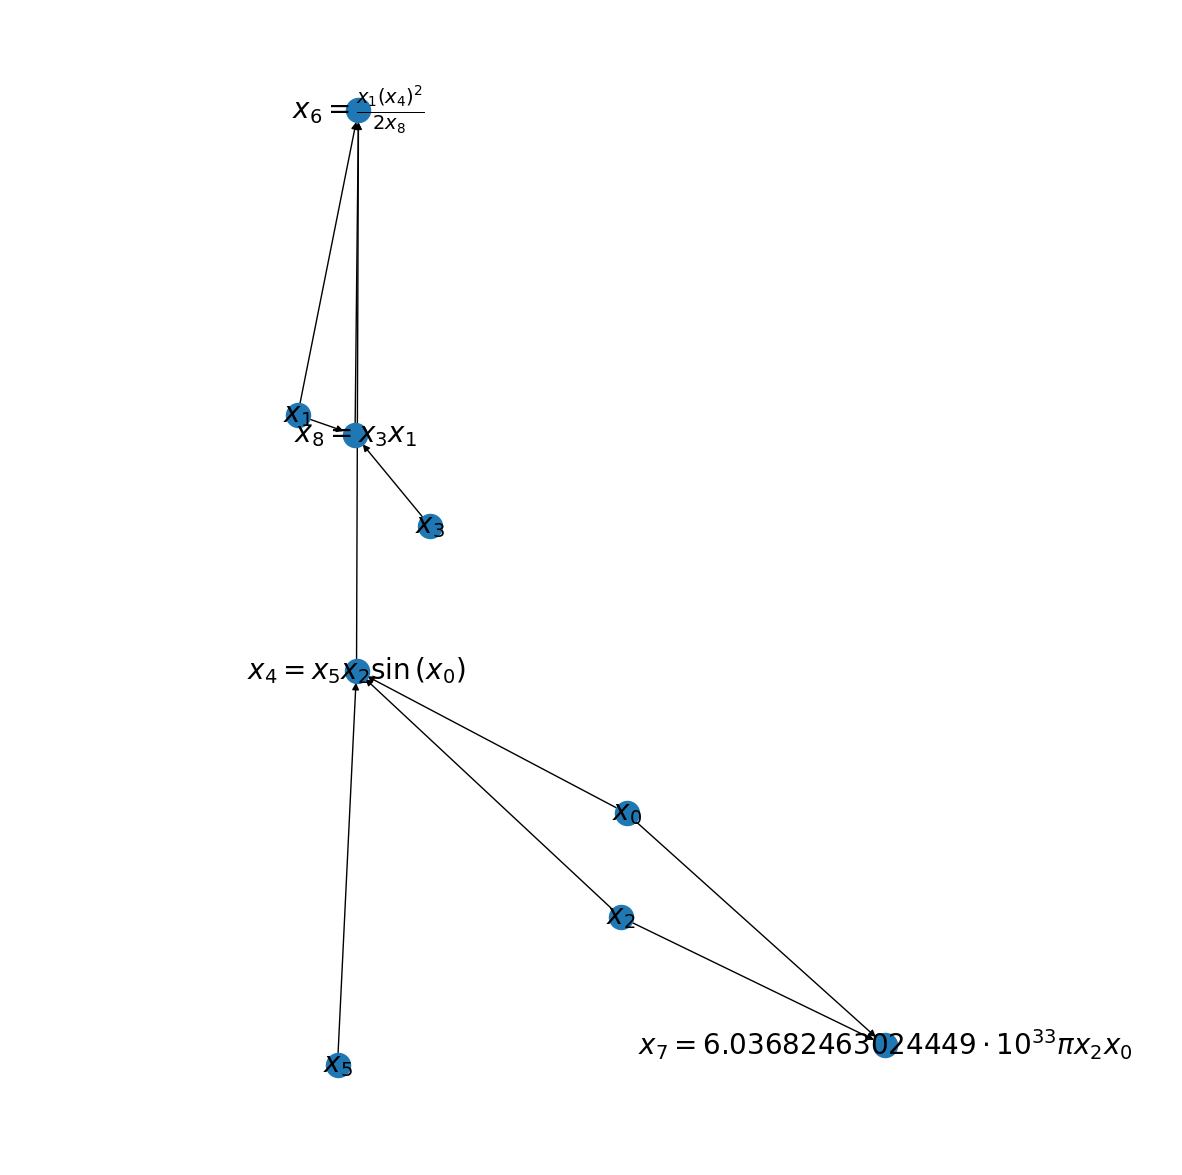

In [35]:
plt.figure(figsize=(15,15))
plt.margins(x=0.4)
nx.draw(G,with_labels=True,labels=nx.get_node_attributes(G,'equation'),font_size=20)

In [36]:
df.to_csv('complex toy.csv',index=False)

In [37]:
with open("complex toy graph.p", 'wb') as f:
    pickle.dump(G, f)